<font size="6"><b>Random Forest - Balanced </b></font>

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
import datetime, warnings, scipy
warnings.filterwarnings("ignore")

from sklearn import metrics, linear_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from scipy.optimize import curve_fit
from sklearn.svm import SVC
from random import sample

import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, LabelBinarizer

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats

# Data Loading & QC

In [2]:
dfm = pd.read_csv('dfm.csv', index_col=0)
dfm.head()

,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DAY,MONTH,FLIGHT_STATUS,WEEKDAY
0,United Airlines,Newark,Denver,3,-5.0,15.0,3,3,10.0,3,-23.0,268.0,250.0,225.0,1605.0,1,1,0,0
1,United Airlines,Las Vegas,San Francisco,2,-8.0,11.0,2,3,7.0,3,-24.0,99.0,83.0,65.0,414.0,1,1,0,0
2,United Airlines,Santa Ana,Denver,3,-5.0,15.0,3,3,5.0,3,-13.0,134.0,126.0,106.0,846.0,1,1,0,0
3,United Airlines,Ft. Myers,Chicago,3,6.0,19.0,3,3,6.0,3,-2.0,190.0,182.0,157.0,1120.0,1,1,0,0
6,United Airlines,Houston,Las Vegas,2,-3.0,14.0,2,2,6.0,2,-16.0,206.0,193.0,173.0,1222.0,1,1,0,0


In [3]:
dfm.CRS_DEP_TIME.value_counts(normalize=True)

2    0.384188
3    0.365040
4    0.180800
1    0.069971
Name: CRS_DEP_TIME, dtype: float64

In [4]:
dfm.CRS_ARR_TIME.value_counts(normalize=True)

3    0.351728
2    0.314401
4    0.307390
1    0.026481
Name: CRS_ARR_TIME, dtype: float64

In [5]:
dfm.WEEKDAY.value_counts(normalize=True)

0    0.150752
4    0.149194
3    0.148208
2    0.145112
1    0.143837
6    0.141355
5    0.121542
Name: WEEKDAY, dtype: float64

In [6]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3982067 entries, 0 to 7213445
Data columns (total 19 columns):
 #   Column               Dtype  
---  ------               -----  
 0   OP_CARRIER           object 
 1   ORIGIN               object 
 2   DEST                 object 
 3   CRS_DEP_TIME         int64  
 4   DEP_DELAY            float64
 5   TAXI_OUT             float64
 6   WHEELS_OFF           int64  
 7   WHEELS_ON            int64  
 8   TAXI_IN              float64
 9   CRS_ARR_TIME         int64  
 10  ARR_DELAY            float64
 11  CRS_ELAPSED_TIME     float64
 12  ACTUAL_ELAPSED_TIME  float64
 13  AIR_TIME             float64
 14  DISTANCE             float64
 15  DAY                  int64  
 16  MONTH                int64  
 17  FLIGHT_STATUS        int64  
 18  WEEKDAY              int64  
dtypes: float64(8), int64(8), object(3)
memory usage: 607.6+ MB


In [7]:
dfm.shape

(3982067, 19)

In [8]:
dfm.isna().sum()

OP_CARRIER             0
ORIGIN                 0
DEST                   0
CRS_DEP_TIME           0
DEP_DELAY              0
TAXI_OUT               0
WHEELS_OFF             0
WHEELS_ON              0
TAXI_IN                0
CRS_ARR_TIME           0
ARR_DELAY              0
CRS_ELAPSED_TIME       0
ACTUAL_ELAPSED_TIME    0
AIR_TIME               0
DISTANCE               0
DAY                    0
MONTH                  0
FLIGHT_STATUS          0
WEEKDAY                0
dtype: int64

# Data Distribution


In [9]:
def scaling_check(data):
    
    case_count = dfm['FLIGHT_STATUS'].value_counts() # 'data' is our input which will be any of the 3 dataframes created
    print('Legend:')
    print(case_count)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x=case_count.index, y=case_count.values)
    plt.rcParams["figure.facecolor"] = "lightblue"
    plt.title('Data Distribution', fontsize=16)
    plt.xlabel('Flight Status', fontsize=12)
    plt.ylabel('Number of Flights', fontsize=12)
    plt.xticks(range(len(case_count.index)), ['ON TIME(0)', 'DELAYED(1)'])
    plt.show()

Legend:
0    2503954
1    1478113
Name: FLIGHT_STATUS, dtype: int64


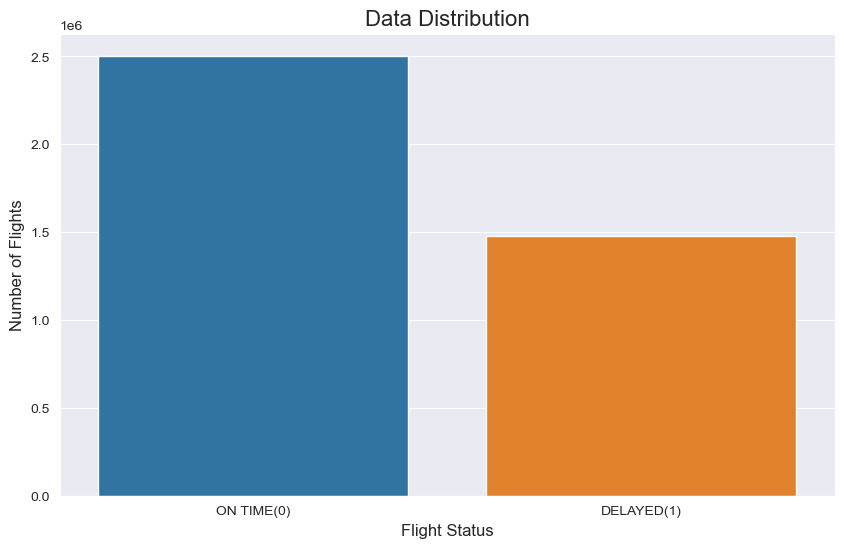

In [10]:
scaling_check(dfm)

In [11]:
dfm.FLIGHT_STATUS.value_counts(normalize=True)

0    0.628808
1    0.371192
Name: FLIGHT_STATUS, dtype: float64

The data is imbalanced with a 62.84% of the flights arriving on time and 37.16% being delayed.]

<b>Weight calculation for each class</b>

In [12]:
dfm.head(2)

,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DAY,MONTH,FLIGHT_STATUS,WEEKDAY
0,United Airlines,Newark,Denver,3,-5.0,15.0,3,3,10.0,3,-23.0,268.0,250.0,225.0,1605.0,1,1,0,0
1,United Airlines,Las Vegas,San Francisco,2,-8.0,11.0,2,3,7.0,3,-24.0,99.0,83.0,65.0,414.0,1,1,0,0


In [13]:
dfm.FLIGHT_STATUS.value_counts()

0    2503954
1    1478113
Name: FLIGHT_STATUS, dtype: int64

In [14]:
count_0 = 2518941
count_1 = 1489316

In [15]:
print(count_0)
print(count_1)

2518941
1489316


In [16]:
initial_bias = np.log([count_1/count_0])
initial_bias

weight_for_0 = (1/count_0)*(count_0 + count_1)/2.0
weight_for_1 = (1/count_1)*(count_0 + count_1)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.80
Weight for class 1: 1.35


As for the previous Random Forest I'll quickly display histogram to better understand the data and just in case you are looking only at this one and not the V1.

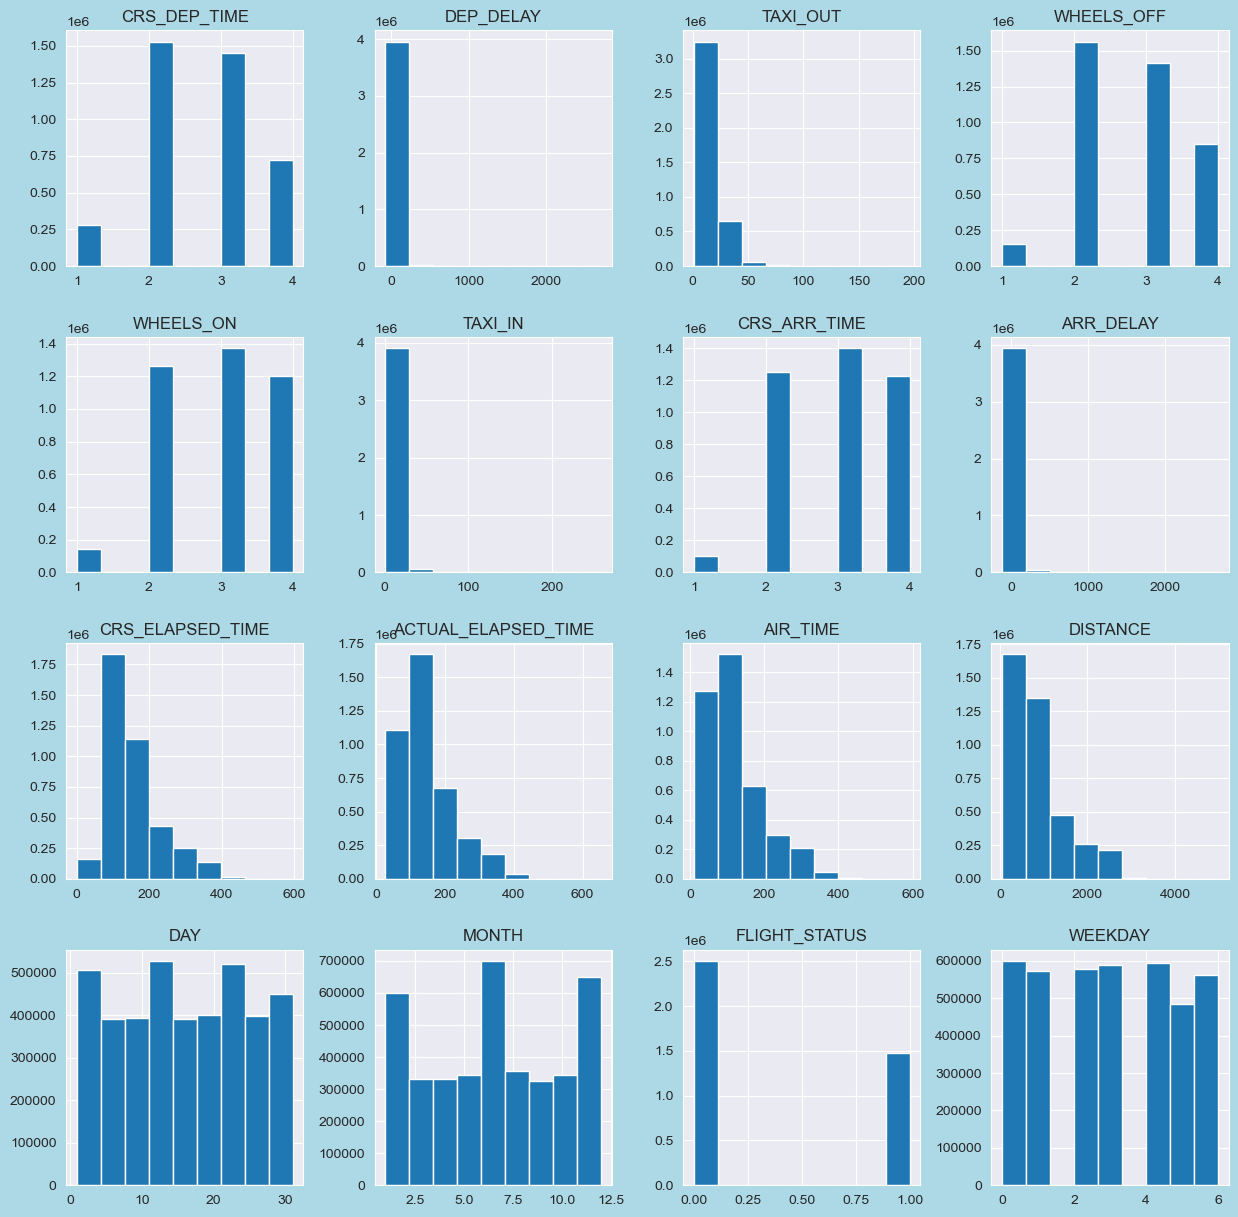

In [17]:
dfm.hist(figsize  = [15, 15],bins=9) 
plt.show()

In [18]:
dfm.DEP_DELAY.value_counts(normalize=True)

-5.0       7.629304e-02
-4.0       7.321298e-02
-3.0       7.112336e-02
-6.0       6.491955e-02
-2.0       6.459962e-02
               ...     
 1271.0    2.511259e-07
 1445.0    2.511259e-07
 1458.0    2.511259e-07
 1394.0    2.511259e-07
 1307.0    2.511259e-07
Name: DEP_DELAY, Length: 1431, dtype: float64

In [19]:
dfm_test=dfm[(dfm['DEP_DELAY'] > 1000)]
dfm_test

,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DAY,MONTH,FLIGHT_STATUS,WEEKDAY
7521,SkyWest Airlines,Eau Claire,Chicago,1,1041.0,18.0,4,4,7.0,2,1032.0,82.0,73.0,48.0,269.0,1,1,1,0
8227,SkyWest Airlines,Atlanta,Chicago,3,1140.0,26.0,2,2,13.0,3,1144.0,130.0,134.0,95.0,606.0,1,1,1,0
14275,American Airlines,Eagle,Dallas-Fort Worth,3,1144.0,17.0,2,3,14.0,4,1135.0,133.0,124.0,93.0,721.0,1,1,1,0
14636,American Airlines,Detroit,Dallas-Fort Worth,3,1013.0,34.0,2,2,8.0,4,1001.0,189.0,177.0,135.0,986.0,1,1,1,0
21972,Spirit Airlines,Detroit,Denver,3,1332.0,48.0,3,3,9.0,4,1345.0,202.0,215.0,158.0,1123.0,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7202763,United Airlines,Eagle,Newark,3,1306.0,18.0,2,3,8.0,4,1271.0,241.0,206.0,180.0,1725.0,31,12,1,0
7203678,Endeavor Air,Traverse City,Detroit,3,1231.0,21.0,3,3,12.0,4,1226.0,78.0,73.0,40.0,207.0,31,12,1,0
7211246,SkyWest Airlines,Minneapolis,Houston,4,1074.0,20.0,3,3,10.0,4,1068.0,192.0,186.0,156.0,1034.0,31,12,1,0
7212368,SkyWest Airlines,Aspen,San Francisco,4,1041.0,29.0,3,3,8.0,4,1026.0,156.0,141.0,104.0,848.0,31,12,1,0


# Categoricals

In [20]:
dfm.columns

Index(['OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_DELAY',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'DAY', 'MONTH', 'FLIGHT_STATUS', 'WEEKDAY'],
      dtype='object')

I have a few Categoricals to deal with:<br>

* OP_CARRIER = 18 airlines<br>
* ORIGIN = 20 cities<br>
* DEST = 20 cities<br>
* CRS_DEP_TIME = 4 quarters<br>
* CRS_ARR_TIME = 4 quarters<br>
* MONTH = 12 months<br>
* FLIGHT_STATUS = 2 categories (already dealt with)<br>
* WEEKDAY = 7 days (from 0 to 6)



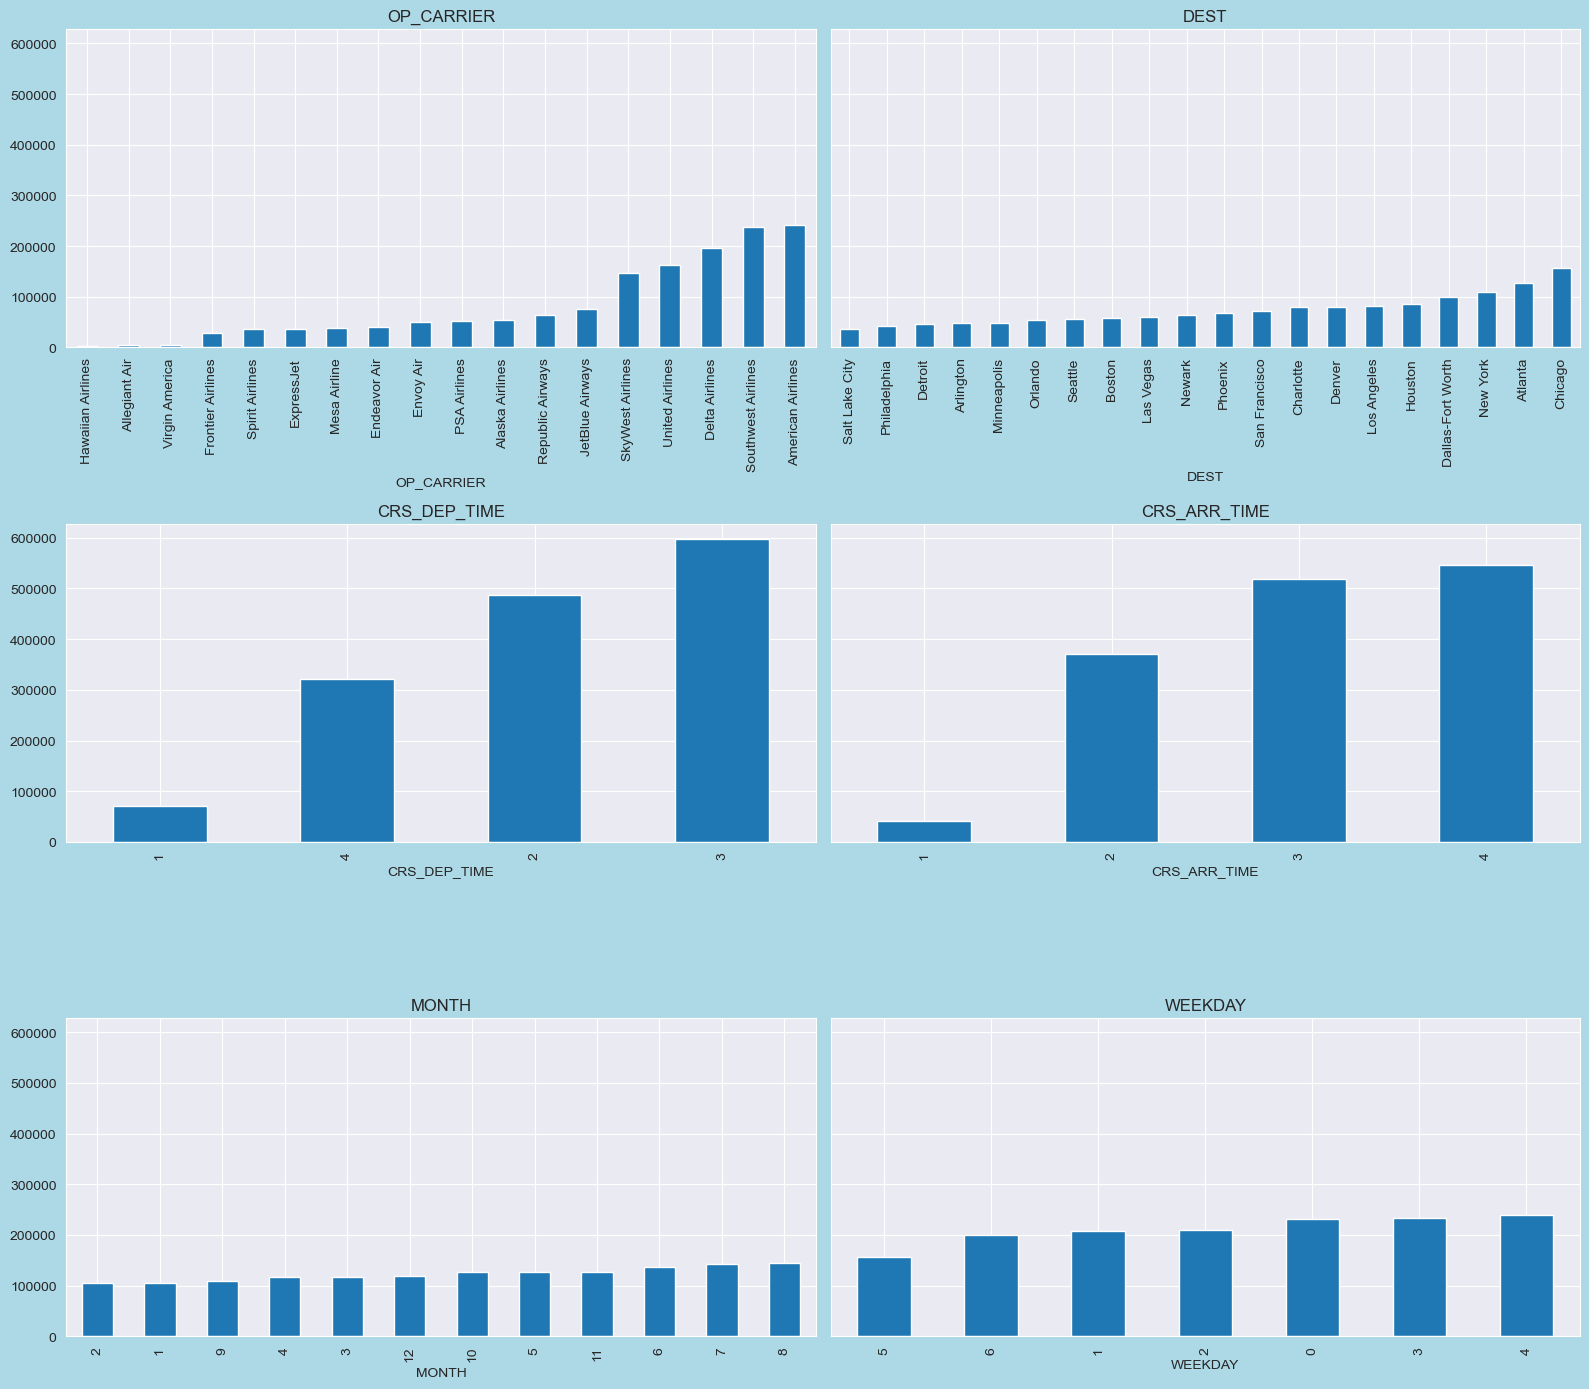

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,14), sharey=True)

categoricals = ['OP_CARRIER', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'MONTH', 'WEEKDAY']

for col, ax in zip(categoricals, axes.flatten()):
    (dfm.groupby(col).sum()['FLIGHT_STATUS'].sort_values().plot.bar(ax=ax))
    
    ax.set_title(col)
    
fig.tight_layout()


In [22]:
OP_CARRIER_dummies = pd.get_dummies(dfm['OP_CARRIER'], prefix='OP_CARRIER', drop_first=True)
DEST_dummies = pd.get_dummies(dfm['DEST'], prefix='DEST', drop_first=True)
CRS_DEP_TIME_dummies = pd.get_dummies(dfm['CRS_DEP_TIME'], prefix='CRS_DEP_TIME', drop_first=True)
CRS_ARR_TIME_dummines = pd.get_dummies(dfm['CRS_ARR_TIME'], prefix='CRS_ARR_TIME', drop_first=True) 
MONTH_dummies = pd.get_dummies(dfm['MONTH'], prefix='MONTH', drop_first=True)
WEEKDAY_dummies = pd.get_dummies(dfm['WEEKDAY'], prefix='WEEKDAY', drop_first=True)

In [23]:
dfm = dfm.drop(['OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'MONTH', 'WEEKDAY', 'ACTUAL_ELAPSED_TIME'], axis=1)

In [24]:
dfm = pd.concat([dfm, OP_CARRIER_dummies, DEST_dummies, CRS_DEP_TIME_dummies, CRS_ARR_TIME_dummines, MONTH_dummies, WEEKDAY_dummies], axis=1)

In [25]:
dfm.head(2)

,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,ARR_DELAY,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,DAY,FLIGHT_STATUS,OP_CARRIER_Allegiant Air,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_Frontier Airlines,OP_CARRIER_Hawaiian Airlines,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_Republic Airways,OP_CARRIER_SkyWest Airlines,OP_CARRIER_Southwest Airlines,OP_CARRIER_Spirit Airlines,OP_CARRIER_United Airlines,OP_CARRIER_Virgin America,DEST_Atlanta,DEST_Boston,DEST_Charlotte,DEST_Chicago,DEST_Dallas-Fort Worth,DEST_Denver,DEST_Detroit,DEST_Houston,DEST_Las Vegas,DEST_Los Angeles,DEST_Minneapolis,DEST_New York,DEST_Newark,DEST_Orlando,DEST_Philadelphia,DEST_Phoenix,DEST_Salt Lake City,DEST_San Francisco,DEST_Seattle,CRS_DEP_TIME_2,CRS_DEP_TIME_3,CRS_DEP_TIME_4,CRS_ARR_TIME_2,CRS_ARR_TIME_3,CRS_ARR_TIME_4,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,-5.0,15.0,3,3,10.0,-23.0,268.0,225.0,1605.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-8.0,11.0,2,3,7.0,-24.0,99.0,65.0,414.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
dfm.shape

(3982067, 70)

In [27]:
dfm.to_csv('dfm_ready.csv')

# Random Forest

## Features, Labels, Training and Test Data Creation

In [28]:
# Create features (X) and labels (y)
y = dfm['FLIGHT_STATUS']
X = dfm.drop(['FLIGHT_STATUS', 'DEP_DELAY'], axis=1)

In [29]:
# Perform the split
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.25, random_state=42)

## Build Regular Tree as Baseline

In [30]:
# Build a regular tree as baseline
#class_weight = {0:0.3715 ,1:0.6284}
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5, class_weight="balanced")
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5)

We run an importance feature values and then plot them to see which ones are the ones with thee most weight. 

In [31]:
tree_clf.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 3.95126154e-11, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.90839599e-11, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

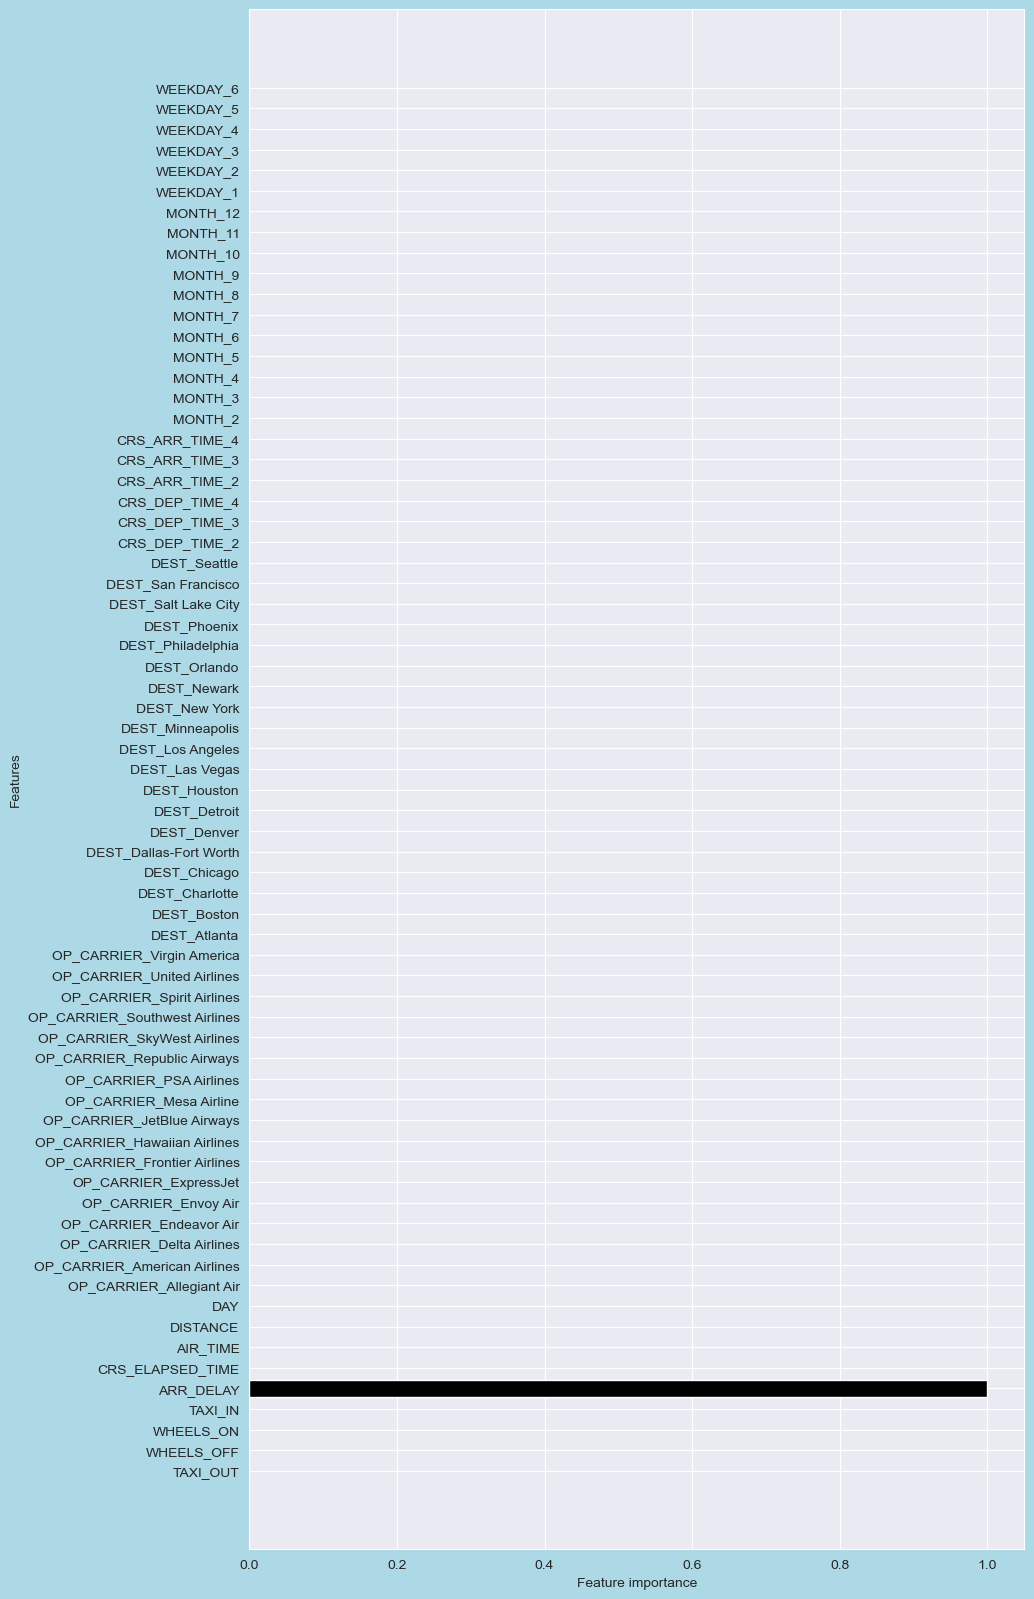

In [32]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(10, 20))
    plt.barh(range(n_features), model.feature_importances_, color='k', align='center')
    plt.yticks(np.arange(n_features), X_train.columns.values)
    plt.xlabel('Feature importance')
    plt.ylabel('Features')
    plt.rcParams["figure.facecolor"] = "lightblue"
    plt.grid(True)
plot_feature_importances(tree_clf)

<b>Model Performance</b>

In [33]:
# Test set predictions
pred = tree_clf.predict(X_test)

In [34]:
# confusion matrix and classfication report
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,1877997,0,1877997
1,0,1108553,1108553
All,1877997,1108553,2986550


In [35]:
print('Classificiation Report')
print('---------------------')
print(classification_report(y_test, pred))

Classificiation Report
---------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1877997
           1       1.00      1.00      1.00   1108553

    accuracy                           1.00   2986550
   macro avg       1.00      1.00      1.00   2986550
weighted avg       1.00      1.00      1.00   2986550



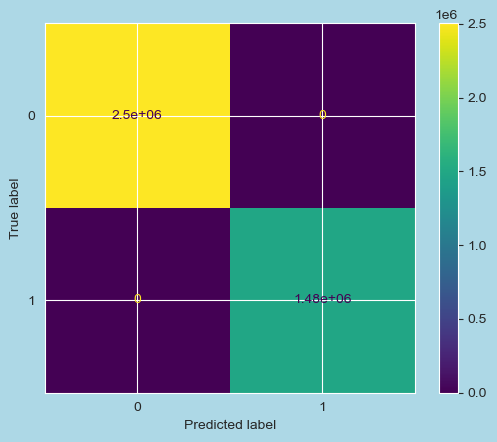

In [36]:
# Alternative confusion matrix
plot_confusion_matrix(tree_clf, X, y, values_format='.3g')
plt.show()

In [37]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, pred) * 100))

Testing Accuracy for Decision Tree Classifier: 100.0%


<b>BAGGED TREES</b>

In [38]:
# We start by instantiating the BaggingClassifire
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=20)

In [39]:
# Now to fitting the training data:
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  n_estimators=20)

In [40]:
# I'm going to call the .score() to obtain the accuracy score on the training dataset and then on the test data:
bagged_tree.score(X_train, y_train)

1.0

In [41]:
bagged_tree.score(X_test, y_test)

1.0

<b>MODEL PERFORMANCE</b>

In [42]:
# Test set predictions
pred_bt = bagged_tree.predict(X_test)

In [43]:
# confusion matrix and classfication report
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, pred_bt, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,1877997,0,1877997
1,0,1108553,1108553
All,1877997,1108553,2986550


In [44]:
print('Classificiation Report')
print('---------------------')
print(classification_report(y_test, pred_bt))

Classificiation Report
---------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1877997
           1       1.00      1.00      1.00   1108553

    accuracy                           1.00   2986550
   macro avg       1.00      1.00      1.00   2986550
weighted avg       1.00      1.00      1.00   2986550



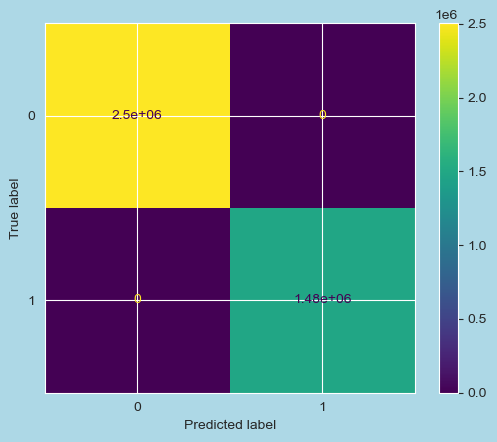

In [45]:
# Alternative confusion matrix
plot_confusion_matrix(bagged_tree, X, y, values_format='.3g')
plt.show()

In [46]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, pred_bt) * 100))

Testing Accuracy for Decision Tree Classifier: 100.0%


## Random Forest With Class Weighting

In [47]:
# I'll start by instantiating the RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight="balanced")
forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5)

In [48]:
# Now to check the accuracy score
forest.score(X_train, y_train)

1.0

In [49]:
# And for the test set:
forest.score(X_test, y_test)

1.0

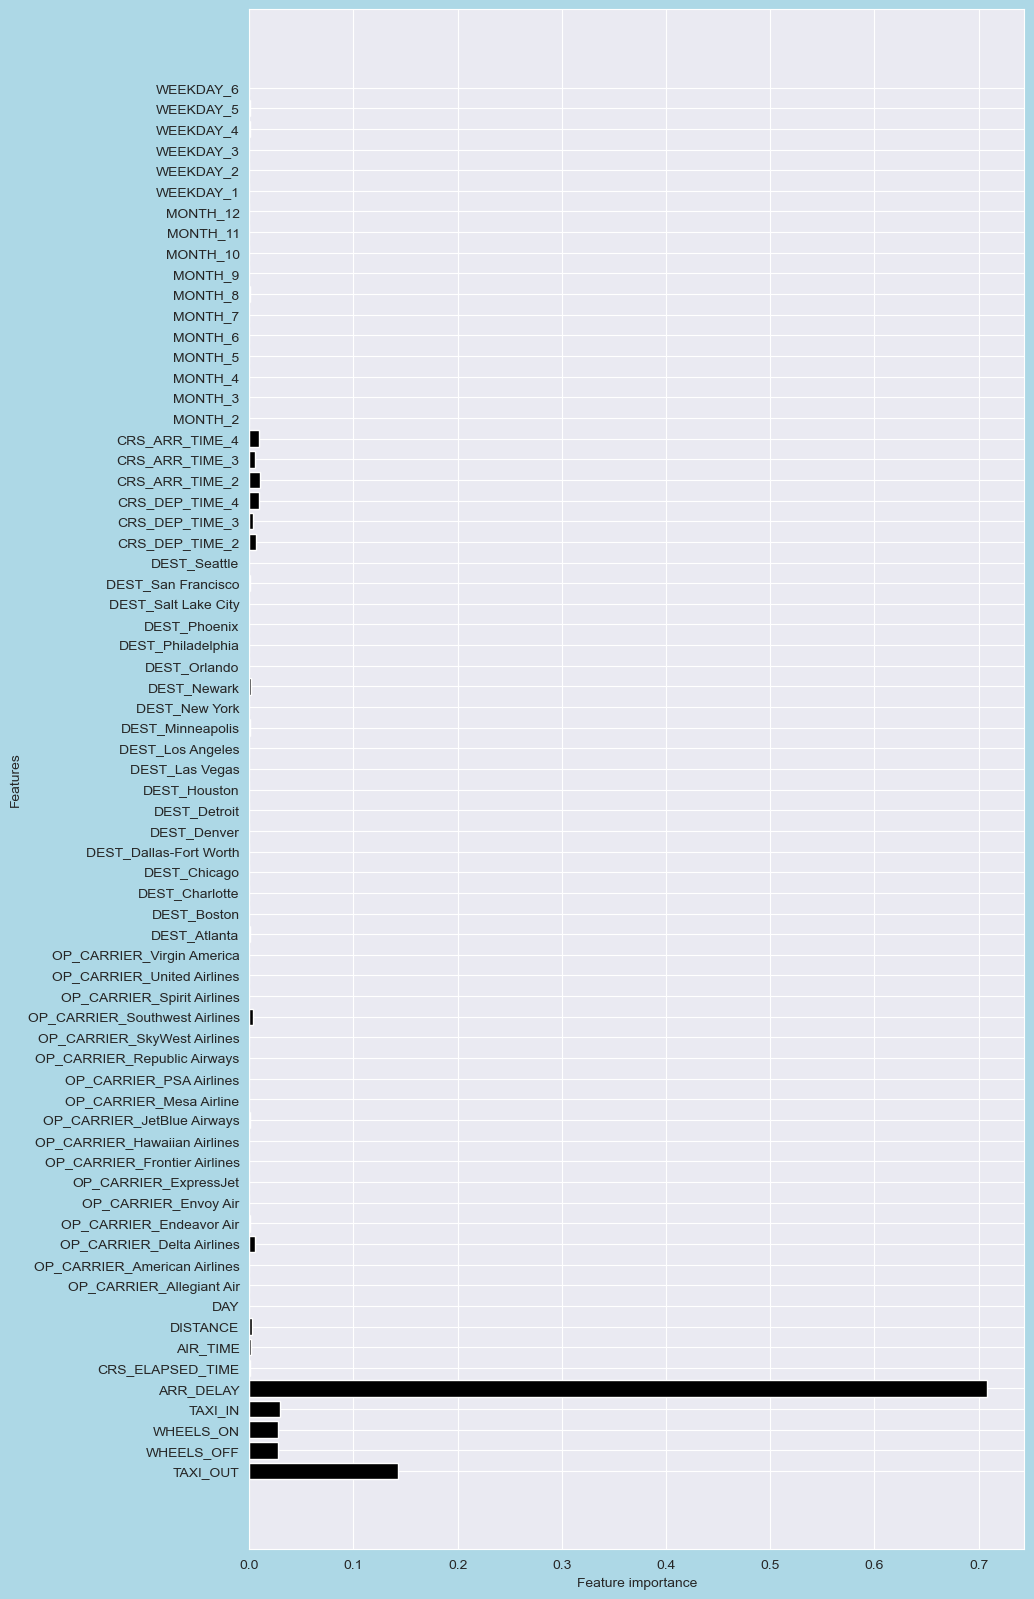

In [50]:
plot_feature_importances(forest)
plt.rcParams["figure.facecolor"] = "lightblue"

<b>MODEL PERFORMANCE</b>

In [51]:
# Test set predictions
pred_rf = forest.predict(X_test)

In [52]:
# confusion matrix and classfication report
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, pred_rf, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,1877997,0,1877997
1,0,1108553,1108553
All,1877997,1108553,2986550


In [53]:
print('Classificiation Report')
print('---------------------')
print(classification_report(y_test, pred_rf))

Classificiation Report
---------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1877997
           1       1.00      1.00      1.00   1108553

    accuracy                           1.00   2986550
   macro avg       1.00      1.00      1.00   2986550
weighted avg       1.00      1.00      1.00   2986550



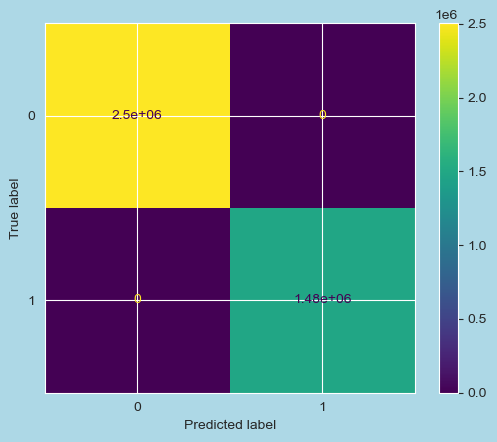

In [54]:
# Alternative confusion matrix
plot_confusion_matrix(forest, X, y, values_format='.3g')
plt.show()

In [55]:
print("Testing Accuracy for RandomForest Classifier: {:.4}%".format(accuracy_score(y_test, pred_rf) * 100))

Testing Accuracy for RandomForest Classifier: 100.0%


In [56]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [57]:
# evaluate model
#scores = cross_val_score(forest, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)


In [58]:
# summarize performance
#print('Mean ROC AUC: %.3f' % mean(scores))

## Random Forest With Bootstrat Class Weighting

In [59]:
forest_bcw = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced_subsample')
forest_bcw.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=5)

In [60]:
# Now to check the accuracy score
forest_bcw.score(X_train, y_train)

1.0

In [61]:
# And for the test set:
forest_bcw.score(X_test, y_test)

1.0

<b>MODEL PERFORMANCE</b>

In [62]:
# Test set predictions
pred_rfbcw = forest_bcw.predict(X_test)

In [63]:
# confusion matrix and classfication report
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, pred_rfbcw, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,1877997,0,1877997
1,0,1108553,1108553
All,1877997,1108553,2986550


In [64]:
print('Classificiation Report')
print('---------------------')
print(classification_report(y_test, pred_rfbcw))

Classificiation Report
---------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1877997
           1       1.00      1.00      1.00   1108553

    accuracy                           1.00   2986550
   macro avg       1.00      1.00      1.00   2986550
weighted avg       1.00      1.00      1.00   2986550



In [65]:
print("Testing Accuracy for RandomForest Classifier: {:.4}%".format(accuracy_score(y_test, pred_rfbcw) * 100))

Testing Accuracy for RandomForest Classifier: 100.0%
